# Experimenting with re-writing the model with PyMC3.

In [7]:
%matplotlib inline

In [376]:
import numpy as np
import pandas as pd
import emcee
import corner

import astropy.stats as aps
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates.builtin_frames.galactocentric \
    import get_matrix_vectors
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

import aviary as av
import theano.tensor as tt

In [430]:
# Solar coords
sun_xyz = [-8.122, 0, 0] * u.kpc
sun_vxyz = [12.9, 245.6, 7.78] * u.km/u.s

galcen_frame = coord.Galactocentric(galcen_distance=np.abs(sun_xyz[0]),
                                    galcen_v_sun=sun_vxyz,
                                    z_sun=0*u.pc)

# Pre-compute the rotation matrix to go from Galactocentric to ICRS
# (ra/dec) coordinates
R_gal, _ = get_matrix_vectors(galcen_frame, inverse=True)

ra_gc_deg, dec_gc_deg = 266.4051, -28.936175
ra_gc, dec_gc = deg_to_rad(np.array([ra_gc_deg, dec_gc_deg]))

eta_deg = 58.5986320306
eta = deg_to_rad(eta_deg)

d_gc = np.abs(sun_xyz[0]).value
zsun = 0

In [431]:
# Calculate prior parameters from vx, vy, vz distributions.
vels = pd.read_csv("../../data/gaia_lamost_mc_velocities.csv")
m = vels.radial_velocity.values != 0
vels = vels.iloc[m]

# Calculate covariance between velocities
VX = np.stack((vels.basic_vx.values, vels.basic_vy.values,
               vels.basic_vz.values, np.log(1./vels.parallax.values)), axis=0)
mean = np.mean(VX, axis=1)
cov = np.cov(VX)

Matrix for calculating Galactocentric positions from equatorial coordinates.

In [478]:
def deg_to_rad(deg):
    return deg * (2 * np.pi) / 360

def r_icrs(ra_deg, dec_deg, d):
    ra, dec = deg_to_rad(np.array([ra_deg, dec_deg]))
    return np.array([[d * np.cos(ra) * np.cos(dec)],
                     [d * np.sin(ra) * np.cos(dec)],
                     [d * np.sin(dec)]])

def eqtogal(ra, dec, d):
    
    r = r_icrs(ra, dec, d)
    R1 = np.array([[np.cos(dec_gc), 0, np.sin(dec_gc)],
                   [0, 1, 0],
                   [-np.sin(dec_gc), 0, np.cos(dec_gc)]])
    R2 = np.array([[np.cos(ra_gc), np.sin(ra_gc), 0],
                   [-np.sin(ra_gc), np.cos(ra_gc), 0],
                   [0, 0, 1]])
    R3 = np.array([[1, 0, 0],
                   [0, np.cos(eta), np.sin(eta)],
                   [0, -np.sin(eta), np.cos(eta)]])
    R1_R2 = np.dot(R1, R2)
    R = np.dot(R3, R1_R2)
    
    xhat = np.array([[1, 0, 0]]).T
    R_r = np.dot(R, r)
    rdash = R_r - d_gc * xhat
    
    theta = np.arcsin(zsun/d_gc)
    H = np.array([[np.cos(theta), 0, np.sin(theta)],
                  [0, 1, 0],
                  [-np.sin(theta), 0, np.cos(theta)]])
    
    rgc = np.dot(H, rdash)
    return rgc

Code for converting km/s to mas/yr.

In [479]:
def cartesian_to_angular_no_units(km_s, kpc):
    to_km_yr = 365.2425 * 24*3600
    to_m_yr = 1000
    to_kpc_yr = 1./3.0856775814671917e+19
    to_rad_yr = 1./kpc
    to_deg_yr = 360/(2*np.pi)
    to_mas_yr = 3600*1000
    return np.arcsin((km_s * to_km_yr) * to_m_yr * to_kpc_yr * to_rad_yr) * to_deg_yr * to_mas_yr

In [488]:
def get_tangent_basis(ra, dec):
    """
    row vectors are the tangent-space basis at (alpha, delta, r)
    ra, dec in radians
    """

    # Precompute this matrix and save for each star.
    M = np.array([
        [-np.sin(ra), np.cos(ra), 0.],
        [-np.sin(dec)*np.cos(ra), -np.sin(dec)*np.sin(ra), np.cos(dec)],
        [np.cos(dec)*np.cos(ra), np.cos(dec)*np.sin(ra), np.sin(dec)]
    ])
    return M


def get_icrs_from_galactocentric(xyz, vxyz, ra, dec, distance):

    # Parameters
#     dx = xyz - sun_xyz
#     dv = vxyz - sun_vxyz

    dx = xyz - sun_xyz.value
    dv = vxyz - sun_vxyz.value

    # M is precomputed for each star, R_gal is same matrix, so just do this
    # dot product.
    proj_dv = M @ R_gal @ dv
        
    # Calculate the unit conversion using 1kms/1km and transform.
#     pm = (proj_dv[:2] / (distance*u.kpc)).to(u.mas/u.yr, u.dimensionless_angles())
    pm = cartesian_to_angular_no_units(proj_dv[:2], distance)

    rv = proj_dv[2]

    return pm, rv

In [492]:
def lnlike_one_star(params, pm, pm_err, pos, pos_err):

    # Unpack parameters and make distance linear.
    vx, vy, vz, lnD = params
    D = np.exp(lnD)

    xyz = eqtogal(pos[0], pos[1], D)

    # Calculate pm and rv from XYZ and V_XYZ
    V_xyz_units = [vx, vy, vz]*u.km*u.s**-1
    vxyz = [vx, vy, vz]
    pm_from_v, rv_from_v = get_icrs_from_galactocentric(xyz[:, 0], vxyz, pos[0], pos[1], D)
    
    # Compare this proper motion with observed proper motion.
#     return -.5*(pm_from_v[0].value - pm[0])**2/pm_err[0]**2 \
#            -.5*(pm_from_v[1].value - pm[1])**2/pm_err[1]**2 \
#            -.5*(1./D - pos[2])**2/pos_err[2]**2

    return -.5*(pm_from_v[0] - pm[0])**2/pm_err[0]**2 \
           -.5*(pm_from_v[1] - pm[1])**2/pm_err[1]**2 \
           -.5*(1./D - pos[2])**2/pos_err[2]**2


def multivariate_lngaussian(pos, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    return -fac / 2 - np.log(N)


def lnprior(params):
    vx, vy, vz, lnD = params
    pos = np.stack((vx, vy, vz, lnD))
    return float(multivariate_lngaussian(pos, mean, cov))


def lnprob(params, pm, pm_err, pos, pos_err):
    return lnlike_one_star(params, pm, pm_err, pos, pos_err) + lnprior(params)

In [493]:
# Format parameter and data arrays.
df = vels.iloc[0]

pos = [df["ra"], df["dec"], df["parallax"]]
pos_err = [df["ra_error"], df["dec_error"], df["parallax_error"]]
pm = [df["pmra"], df["pmdec"]]
pm_err = [df["pmra_error"], df["pmdec_error"]]
inits = [df["basic_vx"], df["basic_vy"], df["basic_vz"],
         np.log(1./df["parallax"])]

M = get_tangent_basis(pos[0], pos[1])

Test lhf.

In [494]:
lnlike_one_star(inits, pm, pm_err, pos, pos_err)

-161294.95394869373

In [495]:
# Run MCMC.
ndim, nwalkers = 4, 16
p0 = np.random.randn(nwalkers, ndim)*1e-2 + inits
sampler = emcee.EnsembleSampler(nwalkers, ndim, av.lnprob,
                                args=(pm, pm_err, pos, pos_err))

nsteps = 100
sampler.run_mcmc(p0, nsteps, progress=True);

# Extract inferred parameters and uncertainties.
flat_samples = sampler.get_chain(discard=int(nsteps/2), flat=True)
params_inferred = np.median(flat_samples, axis=0)

100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


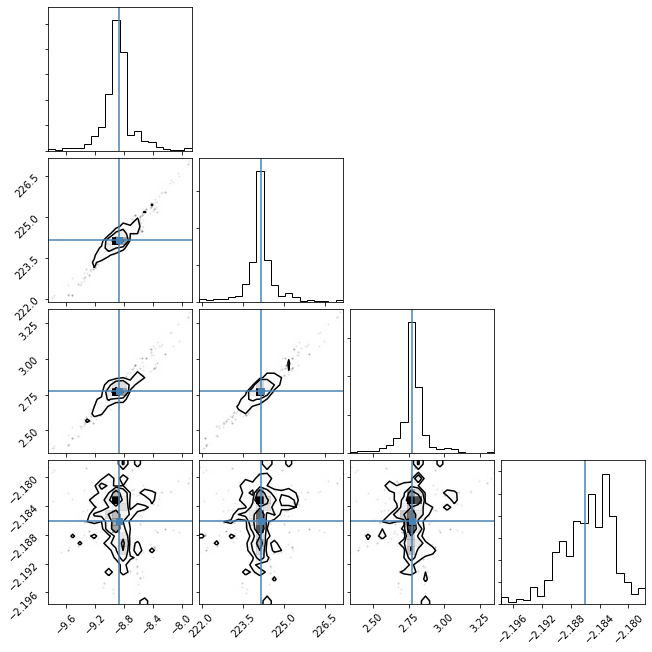

In [496]:
fig = corner.corner(flat_samples, truths=inits);
fig.savefig("corner")

Now try to rewrite this in PyMC3...

In [ ]:
# Things I need:
# A matrix rotation to go from ra, dec, distance to x, y, z.


with pm.Model() as model:
        
    # Set up the parameters
    params = pm.MvNormal("params", mu=mean, cov=cov, shape=(4))

    
    # The model
    
    # Parameters
    dx = xyz - sun_xyz
    dv = vxyz - sun_vxyz

    # M is precomputed for each star, R_gal is same matrix, so just do this
    # dot product.
    proj_dv = M @ R_gal @ dv
    
    # Calculate the unit conversion using 1kms/1km and transform.
    pm = (proj_dv[:2] / (distance*u.kpc)).to(u.mas/u.yr, u.dimensionless_angles())
    rv = proj_dv[2]
    
    

    
    
    
    
    
    
    # Likelihood
    pm.Normal("parallax_obs", mu=mu, sigma=np.array(df.parallax_error),
              observed=np.array(df.parallax_mas))
    
    simple_trace = pm.sample(tune=5000, draws=5000)